In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir("../")

In [3]:
%autoreload 2
from pathlib import Path

import torch
import torch.nn as nn

import random
import math
import ot as pot
import numpy as np
from tqdm.auto import trange
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sb import nn as sbnn
from sb import losses, buffers, metrics
from sb.data import datasets

/Users/ktamogashev/Documents/PhD/projects/sb/sbenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ktamogashev/Documents/PhD/projects/sb/sb/utils.py:171: UserWarning: Path 'external/hamiltorch' does not exist, package. Correstponding modules are not imported.
  warnings.warn(


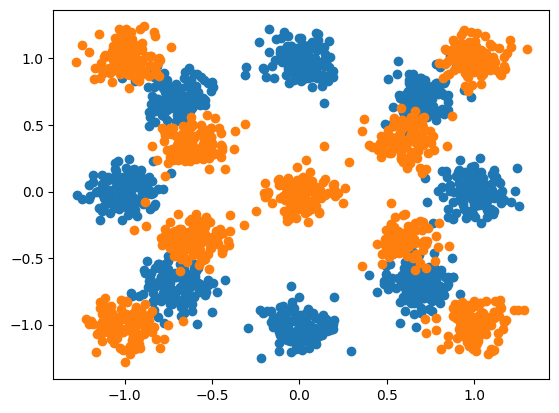

In [7]:
gmm = datasets['mix_of_gaussians'](1, 8, 0.1)
cross = datasets['cross'](1, 0.1)

plt.scatter(*gmm.sample(1000).T)
plt.scatter(*cross.sample(1000).T)

plt.show()

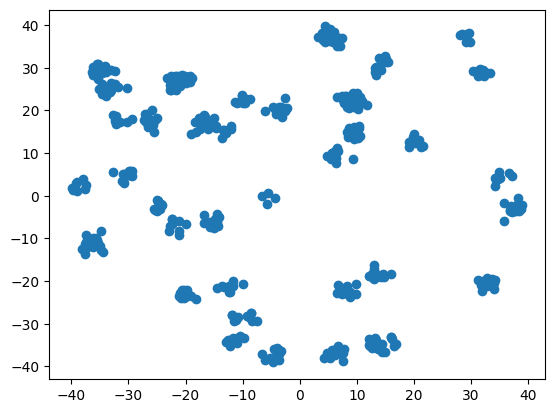

In [50]:
# gmm = datasets['40gmm'](2, 'cpu')

plt.scatter(*gmm.sample(512).T)

In [20]:
class DummyModel:
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, x, t):
        return sbnn.utils.ModelOutput(drift=-self.alpha * x * dt, log_var=0) 

alpha = 0.4
var = 2
n_steps = 20
dt = 0.01
t_max = int(n_steps * dt)

fwd_model = DummyModel(alpha)
x0 = torch.randn(512, 2)

kl = metrics.compute_path_kl(
    fwd_model, 
    x0, dt, t_max, n_steps, alpha, var, 
    method="score"
)
kl

tensor(0.)

In [84]:
def finish_results_table(data, timesteps):
    table = pd.DataFrame(
        {'time': [f"{t=}" for t in timesteps] + ["means"]}
    )
    data = pd.DataFrame(data)
    
    mean_row = [{
        name: val for name, val 
        in zip(data.columns, data.mean(axis=0))
    }]
    data = pd.concat(
        [data, pd.DataFrame(mean_row)], 
        ignore_index=True
    )
    table = pd.concat(
        [table, pd.DataFrame(data)], axis=1
    )
    
    results = [
        f"{round(avg, 3)}±{round(std, 3)}" for avg, std in 
        zip(table.iloc[:, 1:].mean(axis=1), table.iloc[:, 1:].std(axis=1))
    ]
    results[:-1] = [''] * (len(results) - 1)
    table["res"] = results

    table = table.round(3).set_index(table.columns[0])
    return table

In [87]:
import pandas as pd


df = {
    'seed=4': [1, 2,  3],
    'seed=5': [5, 6,  7],
    'seed=6': [9, 10, 11],
}

finish_results_table(df, [*range(len(df['seed=4']))])

,seed=4,seed=5,seed=6,res
time,,,,
t=0,1.0,5.0,9.0,
t=1,2.0,6.0,10.0,
t=2,3.0,7.0,11.0,
means,2.0,6.0,10.0,6.0±4.0


In [30]:
{name: val for name, val in zip(df.columns, df.mean(axis=0))}

{'A': 2.5, 'B': 6.5, 'C': 10.5}

In [31]:
print(df.mean(axis=0))
mean_row = pd.DataFrame([{name: val for name, val in zip(df.columns, df.mean(axis=0))}])

A     2.5
B     6.5
C    10.5
dtype: float64


In [32]:
print(df.mean(axis=0))
mean_row = [{name: val for name, val in zip(df.columns, df.mean(axis=0))}]
df = pd.concat([df, pd.DataFrame(mean_row)], ignore_index=True)
df

A     2.5
B     6.5
C    10.5
dtype: float64


,A,B,C
0,1.0,5.0,9.0
1,2.0,6.0,10.0
2,3.0,7.0,11.0
3,4.0,8.0,12.0
4,2.5,6.5,10.5


In [37]:
gmm = GMM(r=1, n_modes=8, noise=0.1)
lb = DecoupledLangevinBuffer(
    buffer_size=5000,
    p1=gmm,
    langevin_freq=1,
    buffer_sampler='ul2',
    init_step_size=0.01,
    anneal_value=0.1,
    num_langevin_steps=50,
    noise_start_ratio=0.0
)

In [38]:
lb.run_langevin(2)

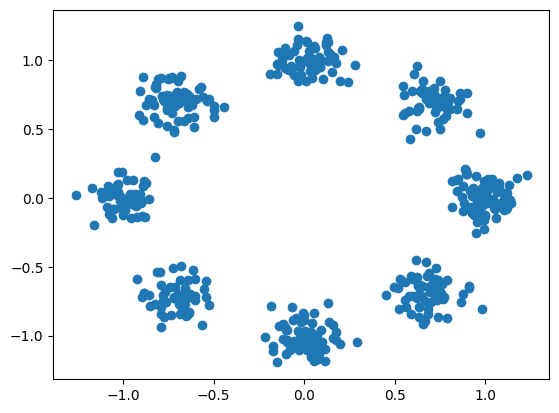

In [39]:
plt.scatter(*lb.sample(500).T)
plt.show()

In [7]:
gmm = GMM(r=1, n_modes=8, noise=0.1)

In [75]:
def get_checkpoint_from_wandb(run_id: str):
    wandb_dir = Path('./wandb')
    run_path = [*wandb_dir.glob(f"*{run_id}")][-1]
    ckpt_path = run_path / 'files' / 'checkpoints' / 'checkpoint-10.pth'
    # ckpt_path = run_path / 'files' / 'checkpoints' / 'checkpoint-final.pth'
    return torch.load(ckpt_path)


In [76]:
fwd_model = SimpleNet(
    t_emb_size=64,
    x_emb_size=64,
    in_dim=2,
    out_dim=2,
    n_main_body_layers=3,
    predict_log_var=True,
    use_residual=False,
)
bwd_model = SimpleNet(
    t_emb_size=64,
    x_emb_size=64,
    in_dim=2,
    out_dim=2,
    n_main_body_layers=3,
    predict_log_var=True,
    use_residual=False,
)
ckpt = get_checkpoint_from_wandb('xnpr9taj')
fwd_model.load_state_dict(ckpt['forward'])
bwd_model.load_state_dict(ckpt['backward'])

x0 = torch.randn(10_000, 2) * 0.7
dt=0.04
t_max=0.8
num_steps=20
alpha=0.0
var=2

In [79]:
fwd_model

SimpleNet(
  (x_embed): Block(
    (block): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
  )
  (t_embed): Block(
    (block): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
  )
  (main_body): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): LayerNorm((64,), eps=1e-05, el

In [77]:
x1 = sample_trajectory_v2(
    fwd_model, bwd_model, x0, dt, 
    t_max, num_steps, alpha, var, 
    direction="fwd", 
    only_last=True, 
    return_timesteps=False, 
    method="ll"
)
x1_true = gmm.sample(x1.size(0))
emd = compute_w2_distance(x1_true, x1)
emd

tensor(0.4517)

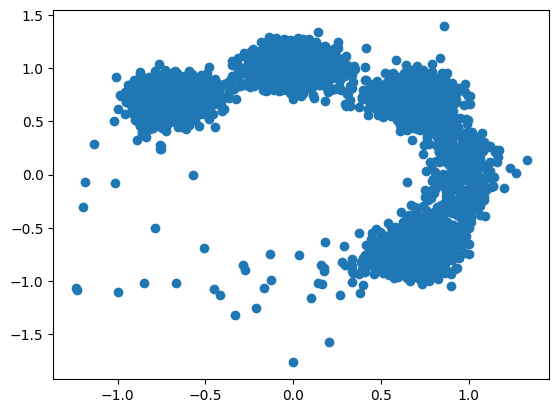

In [78]:
plt.scatter(*x1.T)

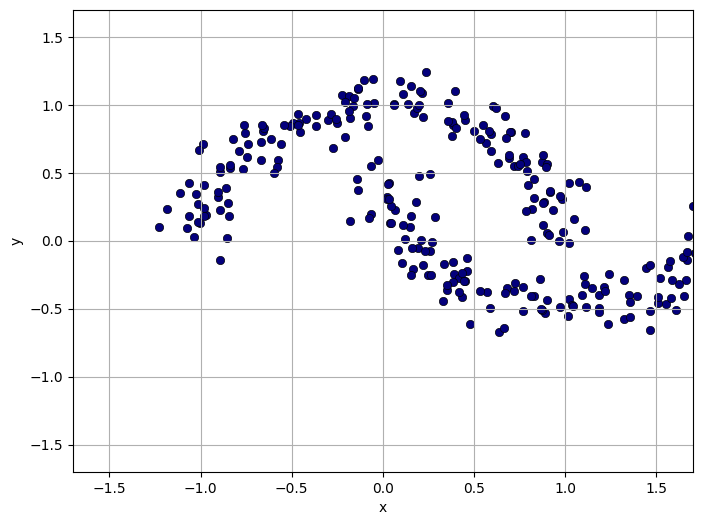

In [16]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate data
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)
traj = [X for _ in range(5)]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], color="#04007C", edgecolor='k')  # deep navy blue
plt.grid(True)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1.7, 1.7)
plt.ylim(-1.7, 1.7)
plt.show()

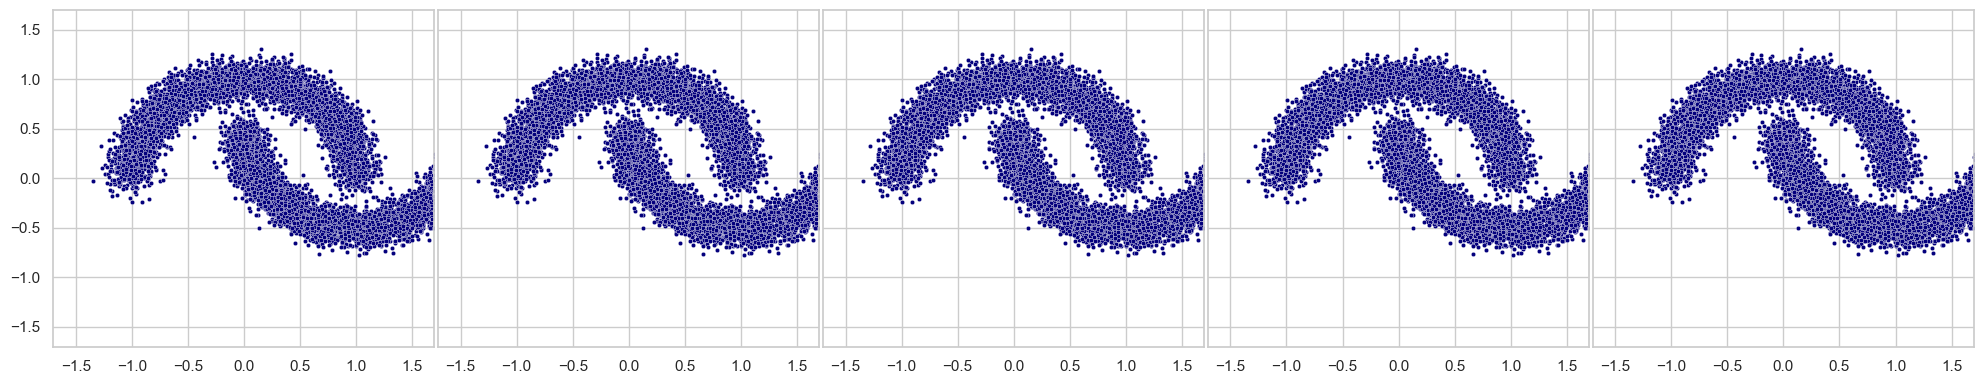

In [54]:
def plot_traj_moons(traj, iteration):
    """
    Plot a list of 2D arrays side-by-side as scatter plots.

    Parameters:
        traj (list of np.ndarray): List where each element is an (N, 2) array representing 2D points.
        color (str): Hex or named color for the scatter dots. Default is deep blue.
    """
    sns.set(style="whitegrid")  # optional: use "ticks" for more minimalist look
    
    num_plots = len(traj)
    fig, axes = plt.subplots(
        1, num_plots, figsize=(4 * num_plots, 4), 
        sharex=True, 
        sharey=True,
    )

    # Handle case when only one subplot is created (not iterable)
    if num_plots == 1:
        axes = [axes]
    
    for i, data in enumerate(traj):
        sns.scatterplot(
            x=data[:, 0], y=data[:, 1],
            ax=axes[i],
            s=10,
            color="#04007C",
            edgecolor='white'
        )
        axes[i].set_xlim(-1.7, 1.7)
        axes[i].set_ylim(-1.7, 1.7)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.01)
    plt.savefig(f'ipf-{iteration}.png')
    # plt.show()


X, y = make_moons(n_samples=10_000, noise=0.1, random_state=42)
traj = [X for _ in range(5)]

plot_traj_moons(traj, 0)

In [7]:
class Net(nn.Module):
    def __init__(self, idim=3, odim=2, hdim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(idim, hdim), nn.SiLU(),
            nn.Linear(hdim, hdim), nn.SiLU(),
            nn.Linear(hdim, hdim), nn.SiLU(),
            nn.Linear(hdim, odim)
        )

    def forward(self, x, t):
        if t.ndim == 0:
            t = torch.ones(x.size(0), 1, device=x.device) * t
        elif t.ndim == 1:
            t = t[:, None]
        
        xt = torch.cat([x, t], dim=1) 
        out = self.net(xt)
        
        if out.size(1) == 4:
            mean, log_var = out.chunk(2, dim=1)
            return ModelOutput(drift=mean, log_var=log_var)
        return ModelOutput(drift=out)

In [8]:
def sf2m_loss(fwd_model, x0, x1, var):
    fwd_model.train()

    t = torch.rand(x0.size(0), 1, device=x0.device)

    z = torch.randn_like(x0)
    xt = t * x1 + (1 - t) * x0 + torch.sqrt(var * t * (1 - t)) * z    
    target_drift = (x1 - x0) + \
                   (xt - t * x1 - (1 - t) * x0) * (1 - 2 * t) / (t * (1 - t)).clip(1e-6)
    lmbda = 2 * (t * (1 - t) / var).sqrt()

    output = fwd_model(xt, t.squeeze(1))
    drift_loss = (target_drift - output.drift).pow(2).sum(1)
    score_loss = (lmbda * output.log_var + z).pow(2).sum(1)

    # score = (t*x1 + (1 - t) * x0 - xt) / (sigma^2 * t * (1 - t))
    # score =  - sigma * sqrt((1 - t)*t)/ (sigma^2 * t * (1 - t))

    return (drift_loss + score_loss).mean()

In [ ]:
n_steps = 20
dt = 1 / n_steps

x = torch.randn(512, 2)
path_kl = 0.0

for t in torch.linspace(0, 1.0, n_steps):
    with torch.no_grad():
        t = torch.ones(x.size(0)) * t
        output = fwd_model(xt, t)

        output = fwd_model(x, t_)
        fwd_mean = x + (output.drift + output.log_var) * dt
        fwd_var = torch.as_tensor(var_ * dt)

        ref_mean = x
        ref_var = torch.as_tensor(var_ * dt)

In [302]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


@torch.no_grad()
def plot_samples(x0, x1, title0, title1, lim=(-2, 2)):
        _, a = plt.subplots(1, 2, figsize=(8, 4))
        
        a[0].scatter(*x0.cpu().T, alpha=0.5, s=2.0)
        a[0].set_title(title0)
        a[0].set_xlim(*lim)
        a[0].set_ylim(*lim)
        
        a[1].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
        a[1].set_title(title1)
        a[1].set_xlim(*lim)
        a[1].set_ylim(*lim)
        plt.show()


@torch.no_grad()
def plot_losses(fwd_losses, bwd_losses, sb_step):
    _ = plt.figure(figsize=(8, 5))
    plt.plot(bwd_losses, label='backward')
    plt.plot(fwd_losses, label='forward')
    plt.title(f'SB Iter {sb_step + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()


def make_fwd_sde_step(z, xt, dt, alpha, g):
    drift = alpha * xt + g * z
    diff = g * math.sqrt(dt)
    return xt + drift * dt + diff * torch.randn_like(xt)


def make_bwd_sde_step(z, xt, dt, alpha, g):
    drift = alpha * xt - g * z
    diff = g * math.sqrt(dt)
    return xt - drift * dt + diff * torch.randn_like(xt)


@torch.no_grad()
def generate_fwd(fwd_model, x0,
                 dt, t_max, num_steps, alpha, var,
                 method="mean", return_trajectory=False):
    if return_trajectory:
        trajectory = [x0]
    
    xt = x0.clone().to(x0.device)
    for t in torch.linspace(dt, t_max, num_steps):
        out, std = get_model_outputs(fwd_model, xt, t - dt, dt, var)
        
        if method  == "ll":
            xt = xt + out * dt + std * torch.randn_like(xt)
        elif method == "mean":
            xt = out + std * torch.randn_like(xt)
        elif method == "eot":
            xt = out + std * torch.randn_like(xt)
        elif method == "score":
            xt = xt + out + std * torch.randn_like(xt)
        elif method == "sde":
            xt = make_fwd_sde_step(out, xt, dt, alpha, var)
        else:
            raise ValueError(f"Unknown method {method}")
        
        if return_trajectory:
            trajectory.append(xt.clone())
    
    if return_trajectory:
        return trajectory
    
    return xt


@torch.no_grad()
def generate_bwd(bwd_model, x1,
                 dt, t_max, num_steps, alpha, var,
                 method="mean", return_trajectory=False):
    if return_trajectory:
        trajectory = [x1]
    
    xt = x1.clone().to(x1.device)
    for t in torch.linspace(t_max, dt, num_steps):
        t = torch.ones(xt.size(0), device=xt.device) * t
        out, std = get_model_outputs(bwd_model, xt, t, dt, var)
        
        if method  == "ll":
            xt = xt + out * dt + std * torch.randn_like(xt)
        elif method == "mean":
            xt = out + std * torch.randn_like(xt)
        elif method == "eot":
            xt = out + std * torch.randn_like(xt)
        elif method == "score":
            xt = xt + out + std * torch.randn_like(xt)
        elif method == "sde":
            xt = make_bwd_sde_step(out, xt, dt, alpha, var)
        else:
            raise ValueError(f"Unknown method {method}")

        if return_trajectory:
            trajectory.append(xt.clone())
    
    if return_trajectory:
        return trajectory
    
    return xt

In [306]:
set_seed(3845)
device = torch.device("mps")
fwd_model = Net(idim=3, odim=2).to(device)
bwd_model = Net(idim=3, odim=2).to(device)

fwd_optim = torch.optim.Adam(
    fwd_model.parameters(), 
    lr=5e-4, weight_decay=1e-8
)
bwd_optim = torch.optim.Adam(
    bwd_model.parameters(), 
    lr=5e-4, weight_decay=1e-8
)

dt = 0.01
num_proc_steps = 20
t_max = num_proc_steps * dt
method = 'sde'  # Options: 'mean', 'll', 'sde, 'score', 'eot, 'dsbm', dsbm++'

batch_size = 512
var = 1.0
num_fwd_steps = 500
num_bwd_steps = 500
num_sb_train_steps = 20


p1 = GMM(r=1, n_modes=8, noise=0.1)
data_var = p1.sample(10_000).to(device).var()
alpha = 1 / data_var

bwd_losses, fwd_losses = [], []

def reference_process(x, t):
    if method in {'mean', 'll', 'eot'}:
        return ModelOutput(drift=(1 - alpha * dt) *  x)
    if method == 'sde':
        return ModelOutput(drift=0)
    if method == 'score':
        return ModelOutput(drift=-alpha * x * dt)

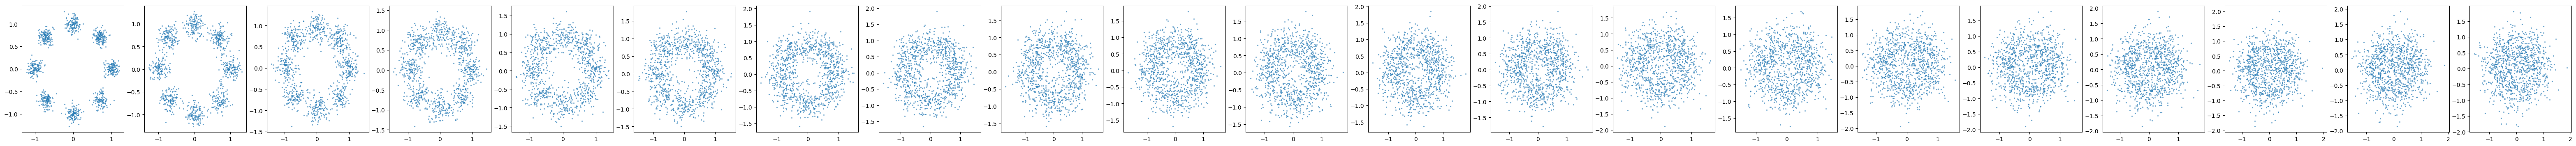

In [ ]:
x1 = p1.sample(1000).to(device)
f, a = plt.subplots(1, num_proc_steps + 1, figsize=(4 * num_proc_steps, 4))
a[0].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
for i, t in enumerate(torch.linspace(t_max, dt, num_proc_steps)):
    t = torch.ones(x1.size(0), device=x1.device) * t
    out = reference_process(x1, t)
    x1 = make_bwd_sde_step(out.drift, x1, dt, alpha, math.sqrt(var))
    a[i+1].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
plt.show()

In [301]:
set_seed(3845)
for sb_step in range(num_sb_train_steps):
    # TRAINING FORWARD MODEL
    for fwd_it in trange(num_fwd_steps, leave=False, 
                         desc=f"Fwd training, SB step {sb_step + 1}"):
        fwd_optim.zero_grad(set_to_none=True)

        fwd_loss = 0
        x0 = torch.randn(batch_size, 2, device=device) * data_var.sqrt()
        x1 = p1.sample(batch_size).to(device)
        _bwd_model = reference_process if sb_step == 0 else bwd_model
        loss = compute_fwd_tlm_loss_v2(fwd_model, _bwd_model, x0, x1, 
                                       dt, t_max, num_proc_steps, alpha, var,
                                       backward=True, method=method)   
        fwd_optim.step()
        fwd_losses.append(loss.item() / num_proc_steps)

    # TRAINING BACKWARD MODEL
    for bwd_step in trange(num_bwd_steps, leave=False, 
                           desc=f"Bwd training, SB step {sb_step + 1}"):
        bwd_optim.zero_grad(set_to_none=True)
        
        x0 = torch.randn(batch_size, 2, device=device) * data_var.sqrt()
        x1 = p1.sample(batch_size).to(device)
        loss = compute_bwd_tlm_loss_v2(fwd_model, bwd_model, x0, x1,
                                       dt, t_max, num_proc_steps, alpha, var,
                                       backward=True, method=method)
        bwd_optim.step()
        bwd_losses.append(loss.item() / num_proc_steps)

    clear_output(wait=True)

    # Plotting losses
    plot_losses(fwd_losses, bwd_losses, sb_step)

    # Plotting forward sampling
    x0 = torch.randn(5000, 2, device=device) * data_var.sqrt()
    x1 = sample_trajectory_v2(fwd_model, x0, 
                              dt, t_max, num_proc_steps, alpha, var, "fwd", 
                              only_last=True, method=method)     
    plot_samples(x0, x1, 'x0 ~ p0', 'x1 ~ P_fwd(·|x0)', lim=(-2.5, 2.5))

    # Plotting backward sampling
    x1 = p1.sample(5000).to(device)
    x0 = sample_trajectory_v2(bwd_model, x1, 
                              dt, t_max, num_proc_steps, alpha, var, "bwd", 
                              only_last=True, method=method)   
    plot_samples(x1, x0, 'x1 ~ p1', 'x0 ~ P_bwd(·|x1)', lim=(-2.5, 2.5))

    plt.close('all')

Fwd training, SB step 1:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [143]:
from torch.func import jacrev, vmap, jvp
from functools import partial

In [218]:
x = torch.ones(16, 2, device=device)
t = torch.randn(16, 1, device=device)
eps = torch.randn(16, 2, device=device)

In [219]:
def model_fn(x, t):
    x, t = x.unsqueeze(0), t.unsqueeze(0)
    o = torch.cat([x.pow(2).sum(1, keepdim=True), -0.5 * x.pow(2).sum(1, keepdim=True)], dim=1)
    return o.squeeze(0)

batch_jacobian = vmap(jacrev(model_fn, argnums=0))(x, t)
trace_true = torch.vmap(torch.trace)(batch_jacobian)
trace_true

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='mps:0')